# Developing an Image Classifier using Deep Learning network and transfer learning

In this project, I'll train an image classifier to recognize image categories.

You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

Please make sure if you are running this notebook in the workspace that you have chosen GPU rather than CPU mode. Deep learning runs way faster on GPU.

In [0]:
# Imports
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
import time
import json
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from collections import OrderedDict
from torch.optim import lr_scheduler
import copy
import pandas as pd

In [2]:
# Show allocated GPU (Google Colab Notebooks specific)
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Apr 30 19:35:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# Show allocated memory (Google Colab Notebooks specific)
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.7 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime → "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [3]:
# Mount a google drive where data are stored (Google Colab Notebooks specific)
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Load the data

Here I use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data  can be downloaded here ([data for download](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz)). The dataset is split into three parts, training, validation, and testing. For the training, we will apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. We'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this we don't want any scaling or rotation transformations, but we'll need to resize then crop the images to the appropriate size.

The pre-trained networks I will use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets we'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

## Load the data and apply transformations


In [0]:
'''
  User-configuration window allowing you to reference our deep learning network 
  to your dataset and train it against it. 
  
  You can configure here image augmentation that will be used for training data.
'''

# Define folders
google_drive_dir = '/content/drive/My Drive/Colab Notebooks/'
data_dir = google_drive_dir + 'data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

# Define number of possible categories that our network must recognize in your data
labels_output_categories = 102

# File with maping between label ids and their names
label_map_file = google_drive_dir + "/cat_to_name.json"

# Define means and stds for images
means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]

# Define  transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([
    # data augmentation
    transforms.RandomRotation(45),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224),
    # data normalization
    transforms.ToTensor(),
    transforms.Normalize(means,stds)
])

testing_transforms = transforms.Compose([
    # data normalization
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(means,stds)
])

validation_transforms = transforms.Compose([
    # data normalization
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(means,stds)
])


In [0]:
# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(test_dir, transform=testing_transforms)
validation_data = datasets.ImageFolder(valid_dir, transform=validation_transforms)

# Define the dataloaders using the image datasets and image transformations 

dataloaders = {'train': torch.utils.data.DataLoader(train_data, batch_size=16, num_workers=0, shuffle=True),
              'test': torch.utils.data.DataLoader(test_data, batch_size=16, num_workers=0),
               'validation': torch.utils.data.DataLoader(validation_data, batch_size=16, num_workers=0)
              }
dataset_sizes = {'train': len(dataloaders['train']),
              'test': len(dataloaders['test']),
               'validation': len(dataloaders['validation'])}

## Label mapping

We'll also need to load in a mapping from category label to category name. We can find this in the file `cat_to_name.json`. It's a JSON object which we can read with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [9]:
# Load naming of output categories
with open(label_map_file, 'r') as f:
    label_map = json.load(f)

label_map

{'1': 'pink primrose',
 '10': 'globe thistle',
 '100': 'blanket flower',
 '101': 'trumpet creeper',
 '102': 'blackberry lily',
 '11': 'snapdragon',
 '12': "colt's foot",
 '13': 'king protea',
 '14': 'spear thistle',
 '15': 'yellow iris',
 '16': 'globe-flower',
 '17': 'purple coneflower',
 '18': 'peruvian lily',
 '19': 'balloon flower',
 '2': 'hard-leaved pocket orchid',
 '20': 'giant white arum lily',
 '21': 'fire lily',
 '22': 'pincushion flower',
 '23': 'fritillary',
 '24': 'red ginger',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '27': 'prince of wales feathers',
 '28': 'stemless gentian',
 '29': 'artichoke',
 '3': 'canterbury bells',
 '30': 'sweet william',
 '31': 'carnation',
 '32': 'garden phlox',
 '33': 'love in the mist',
 '34': 'mexican aster',
 '35': 'alpine sea holly',
 '36': 'ruby-lipped cattleya',
 '37': 'cape flower',
 '38': 'great masterwort',
 '39': 'siam tulip',
 '4': 'sweet pea',
 '40': 'lenten rose',
 '41': 'barbeton daisy',
 '42': 'daffodil',
 '43': 'sword lily',

# Build and train the classifier

Now that the data is ready, it's time to build and train the classifier. We will use one of the pretrained models from `torchvision.models` to get the image features. 

In the next steps we will:
* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) 
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

## Build the model


In [10]:
# Load the pretrained model
model = models.vgg16(pretrained=True)

# Turn off gradients for our model
for param in model.parameters():
    param.requires_grad = False

'''
# VGG16 classifier structure:
        
(classifier): Sequential(
(0): Linear(in_features=25088, out_features=4096, bias=True)
(1): ReLU(inplace)
(2): Dropout(p=0.5)
(3): Linear(in_features=4096, out_features=4096, bias=True)
(4): ReLU(inplace)
(5): Dropout(p=0.5)
(6): Linear(in_features=4096, out_features=1000, bias=True)
'''

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


'\n# VGG16 classifier structure:\n        \n(classifier): Sequential(\n(0): Linear(in_features=25088, out_features=4096, bias=True)\n(1): ReLU(inplace)\n(2): Dropout(p=0.5)\n(3): Linear(in_features=4096, out_features=4096, bias=True)\n(4): ReLU(inplace)\n(5): Dropout(p=0.5)\n(6): Linear(in_features=4096, out_features=1000, bias=True)\n'

In [11]:
# model before modifying its classifier
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
# Define new classifier that we will be learning

#Classifier parameters
def load_classifier():
  classifier_input = 25088 #input layer of vgg16- has 25088
  classifier_hidden_units = 4096 # 4096 default model value
    
  classifier = nn.Sequential(
      nn.Linear(classifier_input, classifier_hidden_units, bias=True),
      nn.ReLU(),
      nn.Dropout(p=0.5),
      nn.Linear(classifier_hidden_units, labels_output_categories),
      nn.LogSoftmax(dim=1)
      # Log softmax activation function ensures that sum of all output probabilities is 1 \
      # - With that we know the confidence the model has for a given class between 0-100%
    )

  return classifier

model.classifier = load_classifier()
model.class_to_idx = train_data.class_to_idx

In [13]:
# model after modifying its classifier - observe the new classifier
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Function to save and load the trained model checkpoint for further usage

After the network will be trained, it's important to save it so next time when we load this notebook or when we will want to use the model in different script for making predictions, we can load it without need to retrain it again.

In [0]:
def save_checkpoint(model, checkpoint_path):
    '''
    Save trained model

    Args:
      model               : instance of deep learning model to be saved e.g. VGG16
      checkpoint_path(str): location to file where the model will be saved, 
                             so it can be loaded and used later without need to traing it again

    Returns:
      None
    '''
    
    model.class_to_idx = test_data.class_to_idx  
    model.cpu()
    torch.save({'arch': 'vgg16',
            'state_dict': model.state_dict(), 
            'class_to_idx': model.class_to_idx},
            checkpoint_path)

In [29]:
def load_checkpoint(filepath, device='cuda'):
    '''
    Load trained model

    Args:
      filepath(str): location to file where the model is saved, 
                      so it can be loaded and used without need to traing it again
    Returns: 
      model: instance of loaded deep learning model
    '''

    check = torch.load(filepath, map_location=device)
    
    if check['arch'] == 'vgg16':
        model = models.vgg16(pretrained = True)
    elif check['arch'] == 'vgg13':
        model = models.vgg13(pretrained = True)
    else:
        print("Error: LoadCheckpoint - Model not recognized")
        return 0   
    
    for param in model.parameters():
        param.requires_grad = False

    model.class_to_idx = check['class_to_idx']
    model.classifier = load_classifier()
        
    model.load_state_dict(check['state_dict'])

    return model
  
model = load_checkpoint('checkpoint_30_04_2020.pth', 'cpu')
if model == 0:
    print ("LoadCheckpoint: ERROR - Checkpoint load failed")
else:
    print ("LoadCheckpoint: Checkpoint loaded") 

LoadCheckpoint: Checkpoint loaded


## Train the model

In [14]:
# Train model
def train_model(model, criterion, optimizer, epochs=7, device='cuda'):
    '''
    Train provided deep learning model

    Args:
      model      : instance of deep learning model to be trained e.g. VGG16
      criterior  : e.g. instance of nn.NLLLoss()
      optimizer  : e.g. instance of optim.SGD()
      epochs(int): number of training epochs that will be executed
      device(str): 'cuda' for using gpu, 'cpu' to run without gpu (not recommended, slow) 

    Returns:
      None
    '''

    print ("train_model start. device: {0}".format(device))
    start = time.process_time()
    
    model.train()
    model.to(device)
    
    running_loss = 0
    print_every = 100 # Define how often the intermediate training status will be printed \
    # - and the model tested against the validation set
    
    for epoch in range(epochs):
        steps = 0
        for images, labels in dataloaders["train"]:
            steps += 1       
            
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            logps = model.forward(images)
            loss = criterion(logps, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            if steps % print_every == 0:

                test_loss = 0
                accuracy = 0

                # model intermediate evaluation during the training
                model.eval()

                # deactivate autograd engine during validation. 
                # - it will reduce memory usage 
                # - it will speed up computations for model validation 
                # - it will disable backpropagation we don't want to have during model validation anyway
                with torch.no_grad(): 
                  for images, labels in dataloaders["validation"]:
                    
                    images, labels = images.to(device), labels.to(device)

                    logps = model.forward(images)
                    loss = criterion(logps, labels)
                    test_loss += loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_ps, top_class = ps.topk(1, dim=1)
                    equality = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equality.type(torch.FloatTensor)).item()
                    
                print("Epoch {0}/{1}".format(epoch+1, epochs))
                print("Steps {0}/{1}".format(steps, dataset_sizes["train"]))
                print("Train loss {:.2}".format(running_loss/print_every))
                print("Validation loss {:.2}".format(test_loss/dataset_sizes["validation"]))
                print("Validation accuracy {:.2}\n".format(accuracy/dataset_sizes["validation"]))

                running_loss = 0

                epoch_end = time.process_time()
                print("Training runtime so far {0}".format(epoch_end - start))
    
    end = time.process_time()
    print("Training finished. Run time: {0}".format(end - start))

# Define criterion and optimizer

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.classifier.parameters(), lr = 0.003)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_model(model, criterion, optimizer, 5, device)

save_checkpoint(model, 'checkpoint.pth')

train_model start. device: cuda
Epoch 1/5
Steps 100/410
Train loss 4.4
Validation loss 3.8
Validation accuracy 0.2

Training runtime so far 40.181274627
Epoch 1/5
Steps 200/410
Train loss 3.8
Validation loss 3.1
Validation accuracy 0.33

Training runtime so far 79.85644389299999
Epoch 1/5
Steps 300/410
Train loss 3.2
Validation loss 2.5
Validation accuracy 0.47

Training runtime so far 119.548478258
Epoch 1/5
Steps 400/410
Train loss 2.8
Validation loss 2.1
Validation accuracy 0.56

Training runtime so far 159.00665579
Epoch 2/5
Steps 100/410
Train loss 2.6
Validation loss 1.6
Validation accuracy 0.68

Training runtime so far 199.63967050000002
Epoch 2/5
Steps 200/410
Train loss 2.1
Validation loss 1.4
Validation accuracy 0.69

Training runtime so far 238.03550184600002
Epoch 2/5
Steps 300/410
Train loss 1.9
Validation loss 1.2
Validation accuracy 0.72

Training runtime so far 276.446062453
Epoch 2/5
Steps 400/410
Train loss 1.7
Validation loss 1.1
Validation accuracy 0.75

Training ru

NameError: ignored

## Test the trained model

It's good practice to test our trained network on test data, images the network has never seen either in training or validation. This will give us a good estimate for the model's performance on completely new images. 

In [0]:
def test_model(model, device="cuda"):
    '''
    Test trained deep learning model

    Args:
      model: instance of deep learning model to be tested e.g. VGG16 against test dataset
      device(str): 'cuda' for using gpu, 'cpu' to run without gpu (not recommended, slow) 

    Returns:
      None
    '''
    model.to(device)
    
    model.eval()
                
    test_loss = 0
    accuracy = 0
        
    steps = 0
    print_every = 100  # Define how often the intermediate training status will be printed \
    
    # deactivate autograd engine during validation. 
    # - it will reduce memory usage 
    # - it will speed up computations for model validation 
    # - it will disable backpropagation we don't want to have during model validation anyway
    with torch.no_grad(): # Turn off gradients for validation, saves memory and computations

        for images, labels in dataloaders["test"]:
            steps += 1

            if steps % print_every == 0:
              print("Steps {0}/{1}".format(steps, dataset_sizes["train"])) 

            images, labels = images.to(device), labels.to(device)

            logps = model.forward(images)
            loss = criterion(logps, labels)
            test_loss += loss.item()
                    
            # Calculate accuracy
            ps = torch.exp(logps)
            top_ps, top_class = ps.topk(1, dim=1)
            equality = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equality.type(torch.FloatTensor)).item()
                    
    print("Validation loss {:.2}".format(test_loss/dataset_sizes["test"]))
    print("Validation accuracy {:.2%}".format(accuracy/dataset_sizes["test"]))  

test_model(model, "cuda")

In [0]:
# if the model is performing well, we can save it under specific name for further use
save_checkpoint(model, "checkpoint_30_04_2020.pth")

## Function to load the checkpoint

Below is the function that can load a checkpoint and rebuild the model. That way we can come back to this project and keep working on it without having to retrain the network.

# Inference for classification

Here I've written a function to use a trained network for inference. That is, we'll pass an image into the network and predict the class of the flower in the image. The function called `predict` takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It looks like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First we'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

I will use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function will process the images in the same manner used for training. 

First, I will resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then I will need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. I will need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. We will want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. We can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [0]:
def process_image(image_path):
    '''
        Process an image into an object that can be used as input to a trained model. 

        Args:
          image_path(str): path to the image
        Returns:
          img_tensor(tensor image)     
    '''    
    
    img = Image.open(image_path)
    
    validation_transforms = transforms.Compose([
      # data normalization
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(means,stds)

      
])
    img_tensor = validation_transforms(img)

    return img_tensor

To check our work, the function below converts a PyTorch tensor and displays it in the notebook. If our `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [0]:
def imshow(image, ax=None, title=None):
     '''
        Display an image on the screen

        Args:
          image(tensor): tensor image
        Returns:
          None    
    '''    
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)

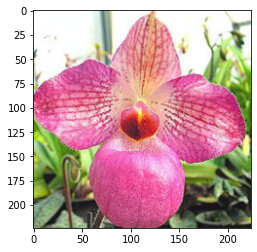

In [0]:
# Test process_image and imshow
image_path_test = data_dir + '/test/2/image_05109.jpg' #image class 2
image = process_image(image_path_test)
imshow(image, ax=None, title=None)

## Class Prediction

Once we can get images in the correct format, it's time to write a function for making predictions with our model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. I will write a function to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. I will need to convert from these indices to the actual class labels using `class_to_idx`. We need invert the dictionary so we get a mapping from index to class as well.

This method will take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [0]:
def predict(image_path, model, device="cpu", top_k=5): 
    '''
        Classify object with its probabilities
        Args: 
            imgage_path(str): path to the image to be classified
            model           : trained model
            device(str)     : computation to be done on 'cpu' or 'cuda'
            top_k(int)      : return top K probabilities
        Returns:
            top_probs, top_classes = predict(image_path, model)
            - top_probs     : top k probabilities
            - top_classes   : top k classes
        
    '''
    img = process_image(image_path)
    top_probs, top_classes = _get_probs_classes(img, top_k, device)
    
    return top_probs, top_classes

In [0]:
'''
    Auxiliary functions for image prediction
'''
def _get_probs_classes(img, top_k, device):
        '''
            Classify object with its probabilities

            Args: 
                img  : Tensor image
                top_k: return top K probabilities
            Returns:
                top_probs[], top_classes[]
                
        '''   
        #Add information about batch size - 1
        model_input = img.unsqueeze(0)
        '''
        model_input.to(device)
        model.to(device)
        model.type(torch.FloatTensor)  #Fix from https://knowledge.udacity.com/questions/23625 | Otherwise RuntimeError: Expected object of type torch.FloatTensor but found type torch.cuda.FloatTensor for argument #2 'weight'
       '''
        probs_log = model.forward(model_input)
        probs = torch.exp(probs_log) 
        
        top_probs, top_classes = probs.topk(top_k)
    
        top_probs = top_probs.detach().numpy().tolist()[0] 
        top_classes = top_classes.detach().numpy().tolist()[0]
        
        return top_probs, top_classes


def get_class_name(model, class_ids):
    '''
        Get name(s) for predicted class_id(s)

        Args:
         model    : trained model
         class_ids: mapping between class ids and their names

        Returns:
          flower_names
    '''
    
    idx_to_class = {val: key for key, val in    
        model.class_to_idx.items()}
    
    flower_names = []
    for c in class_ids:
        flower_names.append(label_map[idx_to_class[c]])
            
    return flower_names

In [0]:
#Test predict function

image_path_test = data_dir + '/train/82/image_01586.jpg' #image class 82


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

probs, classes = predict(image_path_test, model, device)

print (classes)
print (probs)

tensor([[83, 12, 77,  0, 49]])
tensor([[0.9294, 0.0157, 0.0133, 0.0045, 0.0037]], grad_fn=<TopkBackward>)


In [0]:
def plot_probabilities(image_path, model):
    '''
        Draw probabilites with flower itself as requested

        Args:
         image_path(str): path to the image
         model          : trained model

         Returns:
          None
    '''
    plt.figure(figsize = (10,10))
    ax = plt.subplot(2, 1, 1)
    
    flower_num = image_path.split("/")[-2]
    title = label_map[flower_num]
    print("True Flower category: {0}(ID: {1})".format(title, flower_num))
    
    img = process_image(image_path)
    imshow(img, ax, title)
    
    probs, classes = predict(image_path, model)
    #Get names for predicted class_ids
    flower_names = get_class_name(model, classes)
    
    print ("Flower names: {0}".format(flower_names))
    print("Probabilities: {0}".format(probs))
    
    
    plt.subplot(2, 1, 2)
    seaborn.barplot(x=probs, y=flower_names)
    plt.show()



## Sanity Check

Now as we can use a trained model for predictions, let's check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. We will use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

I will convert from the class integer encoding to actual flower names with the `cat_to_name.json` file. To show a PyTorch tensor as an image, I will use the `imshow` function defined above.

True Flower category: english marigold(ID: 5)
Flower names: ['english marigold', 'barbeton daisy', 'sunflower', 'orange dahlia', 'primula']
Probabilities: [0.9829765558242798, 0.014797713607549667, 0.0010831886902451515, 0.00031764659797772765, 0.0002719686890486628]


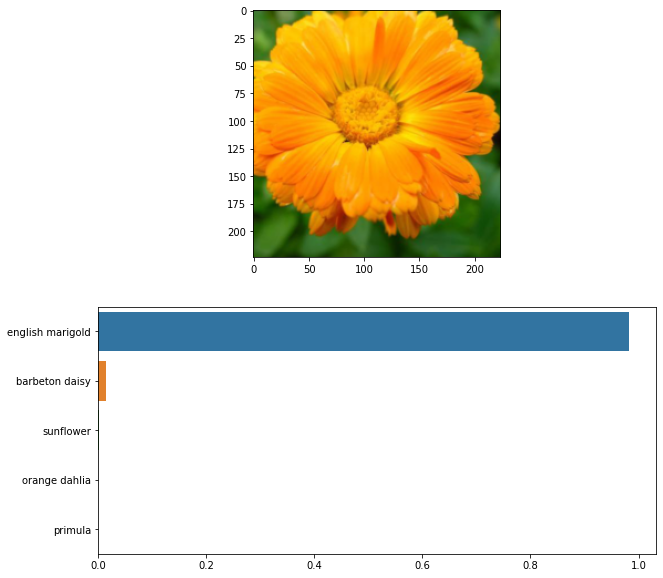

In [0]:
# Display an image along with the top 5 classes
image_path = data_dir + '/test/5/image_05186.jpg'
plot_probabilities(image_path, model)